In [13]:
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,HashingVectorizer
sw = stopwords.words('english')
from re import search
from wordcloud import WordCloud

In [14]:
tweets = pd.read_csv('../../data/judge_1377884607_tweet_product_company.csv')
tweets

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
8716,Ipad everywhere. #SXSW {link},iPad,Positive emotion
8717,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
8718,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
8719,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [15]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


In [16]:
tweets.emotion_in_tweet_is_directed_at.value_counts()

iPad                               910
Apple                              640
iPad or iPhone App                 451
Google                             412
iPhone                             288
Other Google product or service    282
Android App                         78
Android                             74
Other Apple product or service      34
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [17]:
tweets.isna().sum() # lookinf for NaNs

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5552
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [18]:
tweets[tweets['tweet_text'].isna()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,No emotion toward brand or product


In [19]:
tweets.dropna(subset=['tweet_text'],inplace=True)

In [20]:
tweets.isna().sum()

tweet_text                                               0
emotion_in_tweet_is_directed_at                       5551
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [21]:
directed_at_Nan = tweets[tweets['emotion_in_tweet_is_directed_at'].isna()]

In [22]:
directed_at_Nan['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5068
Positive emotion                       292
I can't tell                           142
Negative emotion                        49
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [23]:
#from Saad's notebook

In [24]:
# def get_wordnet_pos(treebank_tag):
#     '''
#     Translate nltk POS to wordnet tags
#     '''
#     if treebank_tag.startswith('J'):
#         return wordnet.ADJ
#     elif treebank_tag.startswith('V'):
#         return wordnet.VERB
#     elif treebank_tag.startswith('N'):
#         return wordnet.NOUN
#     elif treebank_tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN


def doc_preparer(doc, stem = False, stop_words=sw):
    '''

    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    #Stemming seems to work better. Lemming can't identify plurals of products
    
    
#     lemmed_keywords = ['apple',
#                 'ipad', 'ipads',
#                 'iphone', 'iphones',
#                 'itunes',
#                 'google', 'googled',
#                 'android', 'droid', 'androids', 'droids',
#                 'circle', 'circles'
#                 'app', 'apps']

#     stemmed_keywords = ['appl',
#                         'ipad',
#                         'iphon',
#                         'itun',
#                         'googl',
#                         'android',
#                         'droid',
#                         'circl',
#                         'app']

    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
#     doc = pos_tag(doc)
#     doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
#     lemmatizer = WordNetLemmatizer()
#     doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
#     doc = [word for word in doc if word in lemmed_keywords]
    
    
    
    p_stemmer = nltk.stem.PorterStemmer()
    if stem:
        doc = [p_stemmer.stem(word) for word in doc if p_stemmer.stem(word)]
    return ' '.join(doc)

def cv_printScores(cv_metric):
    print('CV Results')
    print('='*32)
    print('Accuracy')
    print('-'*32)
    print(f"Training accuracy: {cv_metric['train_accuracy'].mean():.3f}")
    print(f"Test accuracy:     {cv_metric['test_accuracy'].mean():.3f}")
    print('F-1 Score')
    print('-'*32)
    print(f"Training F1 score: {cv_metric['train_f1_macro'].mean():.3f}")
    print(f"Test F1 score:     {cv_metric['test_f1_macro'].mean():.3f}")

In [25]:
doc_preparer(tweets.tweet_text[0],stem=True,stop_words=sw)

'wesley g iphon hr tweet rise austin dead need upgrad plugin station sxsw'

In [26]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
X = vec.fit_transform(tweets.tweet_text[1:3])

df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df.head()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,also,app,appreciate,awesome,design,fludapp,free,giving,ipad,iphone,jessedee,know,likely,sale,swonderlin,sxsw,they're,ts,wait
0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0
1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,1


In [27]:
def product_identifier(x):
    if "iPad" in x:
        return "Apple"
    elif "iPhone" in x:
        return 'Apple'
    elif "Apple" in x:
        return 'Apple'
    elif "Android" in x:
        return 'Google'
    elif "Google" in x:
        return 'Google'
    else:
        return 'No product'


In [28]:
directed_at_Nan['product_id'] = directed_at_Nan['tweet_text'].apply(product_identifier)

directed_at_Nan.product_id.value_counts()

<ipython-input-28-bb2745934f40>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  directed_at_Nan['product_id'] = directed_at_Nan['tweet_text'].apply(product_identifier)


Apple         2564
Google        1543
No product    1444
Name: product_id, dtype: int64

In [29]:
Neg = tweets[tweets['is_there_an_emotion_directed_at_a_brand_or_product']=='Negative emotion']

In [30]:
Neg

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
17,I just noticed DST is coming this weekend. How...,iPhone,Negative emotion
38,@mention - False Alarm: Google Circles Not Co...,Google,Negative emotion
62,Again? RT @mention Line at the Apple store is ...,NaN,Negative emotion
...,...,...,...
8603,Google guy at #sxsw talk is explaining how he ...,NaN,Negative emotion
8611,I think my effing hubby is in line for an #iPa...,iPad,Negative emotion
8638,I'm pretty sure the panelist that thinks &quot...,Apple,Negative emotion
8672,Hey is anyone doing #sxsw signing up for the g...,NaN,Negative emotion


In [31]:
Neg_word_freq = FreqDist()
for tweet in Neg['tweet_text'].map(lambda x:doc_preparer(x,stem=False)):
    for word in tweet.split():
        Neg_word_freq[word] +=1
Neg_word_freq.most_common(n=50)

[('sxsw', 561),
 ('mention', 305),
 ('ipad', 204),
 ('quot', 169),
 ('iphone', 158),
 ('google', 144),
 ('rt', 136),
 ('apple', 118),
 ('link', 94),
 ('app', 58),
 ('store', 45),
 ('new', 41),
 ('like', 39),
 ('circles', 32),
 ('social', 30),
 ('people', 29),
 ('austin', 28),
 ('design', 27),
 ('apps', 27),
 ('need', 25),
 ('get', 24),
 ('android', 22),
 ('one', 22),
 ('amp', 21),
 ('launch', 21),
 ('today', 20),
 ('would', 19),
 ('line', 18),
 ('think', 18),
 ('time', 17),
 ('headaches', 16),
 ('says', 16),
 ('pop', 16),
 ('day', 16),
 ('long', 16),
 ('fail', 16),
 ('users', 15),
 ('news', 15),
 ('network', 15),
 ('see', 15),
 ('much', 15),
 ('america', 15),
 ('back', 14),
 ('battery', 14),
 ('money', 14),
 ('major', 14),
 ('really', 14),
 ('good', 14),
 ('fascist', 14),
 ('company', 14)]

In [32]:
Pos = tweets[tweets['is_there_an_emotion_directed_at_a_brand_or_product']=='Positive emotion']

In [33]:
Pos

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
...,...,...,...
8701,@mention your iPhone 4 cases are Rad and Ready...,iPhone,Positive emotion
8706,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion
8708,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion
8713,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion


In [34]:
pos_word_freq = FreqDist()
for tweet in Pos['tweet_text'].map(lambda x:doc_preparer(x,stem=False)):
    for word in tweet.split():
        pos_word_freq[word] +=1
pos_word_freq.most_common(n=50)

[('sxsw', 3037),
 ('mention', 2153),
 ('ipad', 1201),
 ('link', 1170),
 ('rt', 933),
 ('apple', 902),
 ('google', 708),
 ('iphone', 532),
 ('store', 528),
 ('quot', 456),
 ('app', 387),
 ('new', 354),
 ('austin', 285),
 ('amp', 204),
 ('pop', 204),
 ('android', 199),
 ('get', 154),
 ('launch', 153),
 ('one', 143),
 ('party', 133),
 ('great', 130),
 ('line', 127),
 ('time', 124),
 ('free', 122),
 ('via', 122),
 ('social', 122),
 ('circles', 121),
 ('cool', 117),
 ('today', 112),
 ('day', 111),
 ('like', 110),
 ('w', 103),
 ('maps', 101),
 ('mobile', 96),
 ('sxswi', 95),
 ('go', 93),
 ('awesome', 91),
 ('good', 91),
 ('love', 90),
 ('network', 88),
 ('opening', 86),
 ('downtown', 85),
 ('check', 84),
 ('temporary', 84),
 ('people', 82),
 ('apps', 82),
 ('got', 79),
 ('see', 72),
 ('popup', 72),
 ('even', 70)]

In [35]:
neg_keys = list(Neg_word_freq.most_common(n=50))

In [36]:
neg_keys = [t[0] for t in neg_keys]

In [37]:
neg_keys

['sxsw',
 'mention',
 'ipad',
 'quot',
 'iphone',
 'google',
 'rt',
 'apple',
 'link',
 'app',
 'store',
 'new',
 'like',
 'circles',
 'social',
 'people',
 'austin',
 'design',
 'apps',
 'need',
 'get',
 'android',
 'one',
 'amp',
 'launch',
 'today',
 'would',
 'line',
 'think',
 'time',
 'headaches',
 'says',
 'pop',
 'day',
 'long',
 'fail',
 'users',
 'news',
 'network',
 'see',
 'much',
 'america',
 'back',
 'battery',
 'money',
 'major',
 'really',
 'good',
 'fascist',
 'company']

In [58]:
pos_keys = list(pos_word_freq.most_common(n=50))

In [59]:
pos_keys = [t[0] for t in pos_keys]

In [60]:
pos_keys

['sxsw',
 'mention',
 'ipad',
 'link',
 'rt',
 'apple',
 'google',
 'iphone',
 'store',
 'quot',
 'app',
 'new',
 'austin',
 'amp',
 'pop',
 'android',
 'get',
 'launch',
 'one',
 'party',
 'great',
 'line',
 'time',
 'free',
 'via',
 'social',
 'circles',
 'cool',
 'today',
 'day',
 'like',
 'w',
 'maps',
 'mobile',
 'sxswi',
 'go',
 'awesome',
 'good',
 'love',
 'network',
 'opening',
 'downtown',
 'check',
 'temporary',
 'people',
 'apps',
 'got',
 'see',
 'popup',
 'even']

In [41]:
list(set(neg_keys).intersection(pos_keys))

['see',
 'network',
 'circles',
 'ipad',
 'day',
 'launch',
 'social',
 'people',
 'google',
 'get',
 'one',
 'like',
 'time',
 'mention',
 'android',
 'iphone',
 'app',
 'quot',
 'rt',
 'line',
 'today',
 'new',
 'apple',
 'apps',
 'store',
 'good',
 'austin',
 'sxsw',
 'amp',
 'pop',
 'link']

In [42]:
unique_pos = [element for element in pos_keys if element not in neg_keys]

In [43]:
unique_pos

['party',
 'great',
 'free',
 'via',
 'cool',
 'w',
 'maps',
 'mobile',
 'sxswi',
 'go',
 'awesome',
 'love',
 'opening',
 'downtown',
 'check',
 'temporary',
 'got',
 'popup',
 'even']

In [44]:
unique_neg = [element for element in neg_keys if element not in pos_keys]

In [45]:
unique_neg

['design',
 'need',
 'would',
 'think',
 'headaches',
 'says',
 'long',
 'fail',
 'users',
 'news',
 'much',
 'america',
 'back',
 'battery',
 'money',
 'major',
 'really',
 'fascist',
 'company']

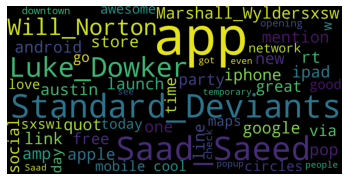

In [75]:
text = [
 'Standard_Deviants',
 'Saad_Saeed',
 'Luke_Dowker',
 'Will_Norton',
 'Marshall_Wylder'
 'sxsw',
 'mention',
 'ipad',
 'link',
 'rt',
 'apple',
 'google',
 'iphone',
 'store',
 'quot',
 'app',
 'new',
 'austin',
 'amp',
 'pop',
 'android',
 'get',
 'launch',
 'one',
 'party',
 'great',
 'line',
 'time',
 'free',
 'via',
 'social',
 'circles',
 'cool',
 'today',
 'day',
 'like',
 'w',
 'maps',
 'mobile',
 'sxswi',
 'go',
 'awesome',
 'good',
 'love',
 'network',
 'opening',
 'downtown',
 'check',
 'temporary',
 'people',
 'apps',
 'got',
 'see',
 'popup',
 'even',
 'Saad']
wc = WordCloud(max_words = 1000,
               width = 1600,
               height = 800,
               collocations=False).generate(",".join(text))
plt.axis("off")
plt.imshow(wc);